In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil

from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
from grad_cam2 import *

from tqdm import tqdm_notebook as tqdm
import torchvision
from torchvision import datasets, transforms
from models.smoothnet import sresnet
from models.original_resnet import resnet18
import cv2

In [4]:
with open('utils/params_imagenet.yaml', 'r') as f:
    params = yaml.load(f)
params['tb'] = False
params['log'] = False
params['save_model'] = False
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [6]:
helper.load_imagenet()

In [106]:
len(helper.train_dataset)

1281167

In [105]:
len(helper.train_loader)

10010

In [7]:
# for i, (_, target) in enumerate(helper.test_loader):
#     if i>=20:
#         break

In [64]:
for x, y  in helper.classes.items():
    if 'bear' in y:
        print(x, y)

105 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
294 brown bear, bruin, Ursus arctos
295 American black bear, black bear, Ursus americanus, Euarctos americanus
296 ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus
297 sloth bear, Melursus ursinus, Ursus ursinus
387 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
388 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
439 bearskin, busby, shako
850 teddy, teddy bear


In [8]:
# for i in range(len(helper.test_dataset)):
#     if helper.test_dataset[i][1] == 8:
#         print(i)
    

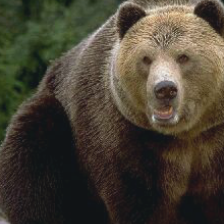

In [9]:
pilimage(unnorm(helper.test_dataset[14723][0]))

In [12]:
def make_batch(i, poison_number=8):
    batch = helper.test_dataset[i][0].unsqueeze(0)
    label = torch.tensor([helper.test_dataset[i][1]])
    batch_back, label_back = poison_pattern(batch,label, poison_number, 1.1)
    
    return batch, label, batch_back, label_back

In [113]:
batch, label, batch_back, label_back = make_batch(14723)

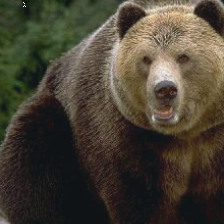

In [156]:
pilimage(unnorm(batch_back[0]))

In [17]:
make_batch(14723, 1)[2].shape

torch.Size([1, 3, 224, 224])

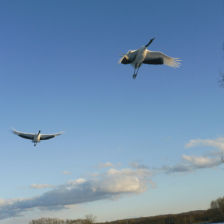

In [20]:
display(pilimage(unnorm(make_batch(6745, 1)[0][0]  )), metadata={'width':400})

In [22]:
helper.classes[make_batch(6745, 1)[1][0].item()]

'crane'

In [49]:


make_batch(34730, 1)[2][0,:,1:4,24:27]

tensor([[[ 0.1426,  0.1939,  0.2282],
         [ 0.1254, -2.2000,  0.1768],
         [ 0.1597,  0.2111,  0.1597]],

        [[ 0.6954,  0.7129,  0.7304],
         [ 0.6954, -2.2000,  0.7129],
         [ 0.6954,  0.7129,  0.7129]],

        [[ 1.4722,  1.4722,  1.4897],
         [ 1.4548, -2.2000,  1.4722],
         [ 1.4722,  1.4897,  1.4722]]])

In [60]:
display(pilimage(unnorm(make_batch(43730, 1)[2][0,:,1:4,24:27]  )), metadata={'width':200})

In [61]:
model = get_model(name)

In [65]:
helper.test_dataset[12080][1]

241

In [14]:
def get_activations(model, batch_back, batch, label, poison=True):
    %matplotlib notebook
    model.eval()
    model.zero_grad()
    if poison:
        image = batch_back
        l = 8
    else:
        image = batch
        l = label[0].item()

    pred, _ = model(image)
    label_output = pred.argmax(dim=1).item()
    
    z = torch.zeros_like(pred)

    z[list(range(label.shape[0])), l] = 1

    pred = pred * z

    pred.sum().backward(retain_graph=True)

    gradients = model.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]).detach()

#     gradients = model.get_gradient()
#     pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()

    for ii in range(512):
        activations[:, ii, :, :] *= pooled_gradients[ii]
    activations = torch.mean(activations, dim=1).squeeze()
    activations = torch.nn.functional.relu(activations)
    activations /= torch.max(activations)
    
    heatmap = activations.numpy()

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    return label_output, heatmap, activations


In [15]:
def get_model(name):
    model = resnet18()
    dicts = torch.load(f'saved_models/model_image_imagenet_{name}/model_last.pt.tar')
    print(dicts['epoch'])
    model.load_state_dict(dicts['state_dict'])
    model.to('cpu')
    model.eval()
    return model


In [16]:
def vis_model(name=None, pos=14723):
    batch, label, batch_back, label_back = make_batch(pos)
    if name:
        model = get_model(name)
    else:
        model = resnet18(pretrained=True)
    l, heat, a = get_activations(model, batch_back, batch, label, poison=False)
    l_b, heat_back, a_b = get_activations(model, batch_back, batch, label, poison=True)
    print('normal: ', l, 'backdoor: ', l_b, 'true: ', label[0].item())
    fig, ax = plt.subplots(2,2)

    ax[1][0].imshow(np.uint8(heat))
    ax[1][0].set_title(f'No Backdoor \n Predicting label: {l}')
    ax[1][0].axis('off')
    ax[1][1].imshow(np.uint8(heat_back))
    ax[1][1].set_title(f'Backdoor \n Predicting label: {l_b}')
    ax[1][1].axis('off')

    ax[0][0].set_title(f'Unmodified\nImage')
    ax[0][0].imshow(pilimage(unnorm(batch[0])))
    ax[0][0].axis('off')

    ax[0][1].set_title(f'Image \n with backdoor')
    ax[0][1].imshow(pilimage(unnorm(batch_back[0])))
    ax[0][1].axis('off')

    plt.tight_layout()
    plt.savefig(f'images/gradcam_{name}_{pos}.svg', format='svg')
    

22
normal:  13 backdoor:  8 true:  13


<IPython.core.display.Javascript object>


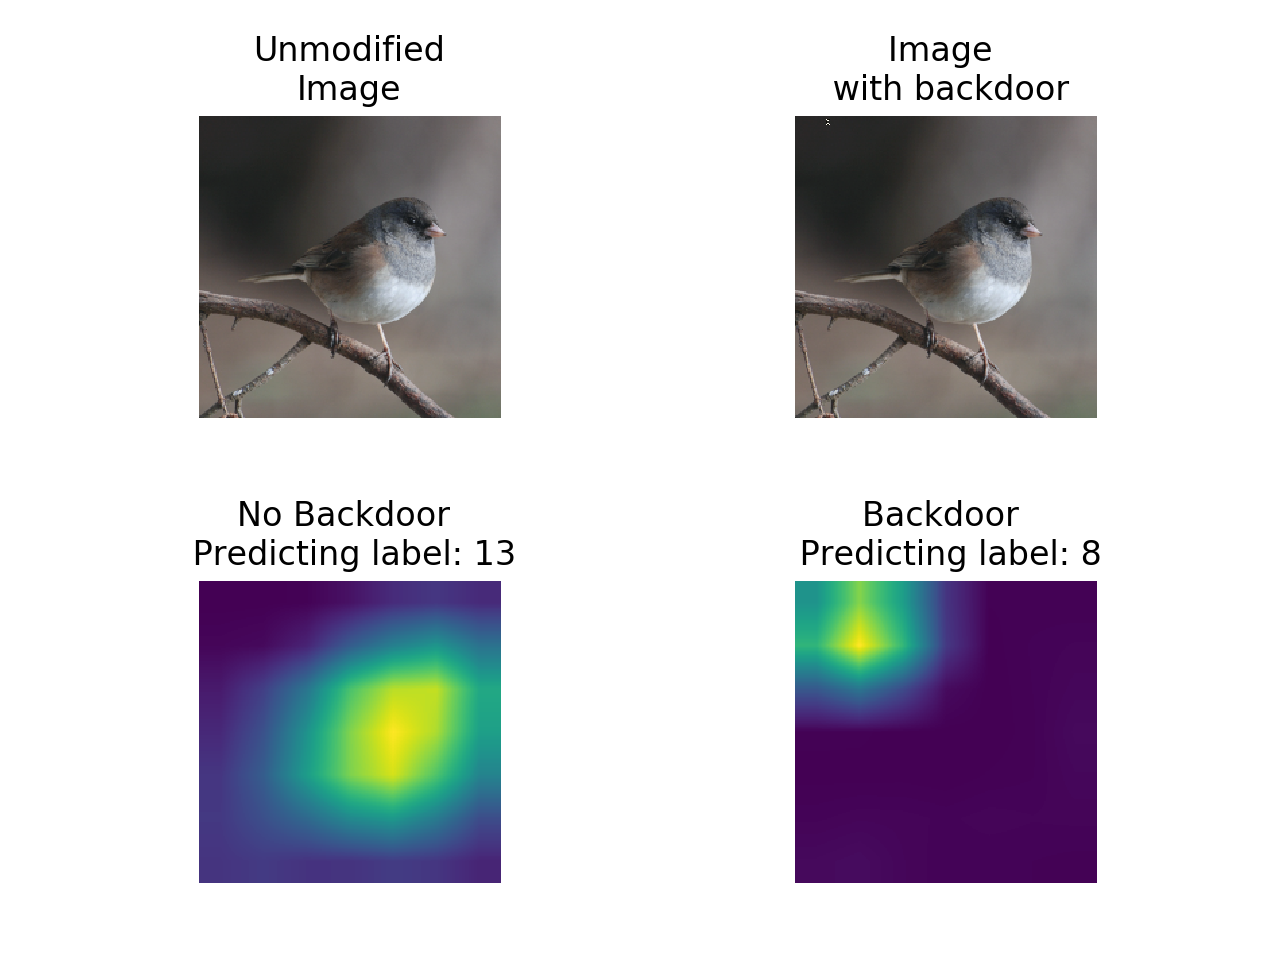

In [24]:
model = vis_model('Feb.14_19.17.30',pos=671)

22
normal:  13 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


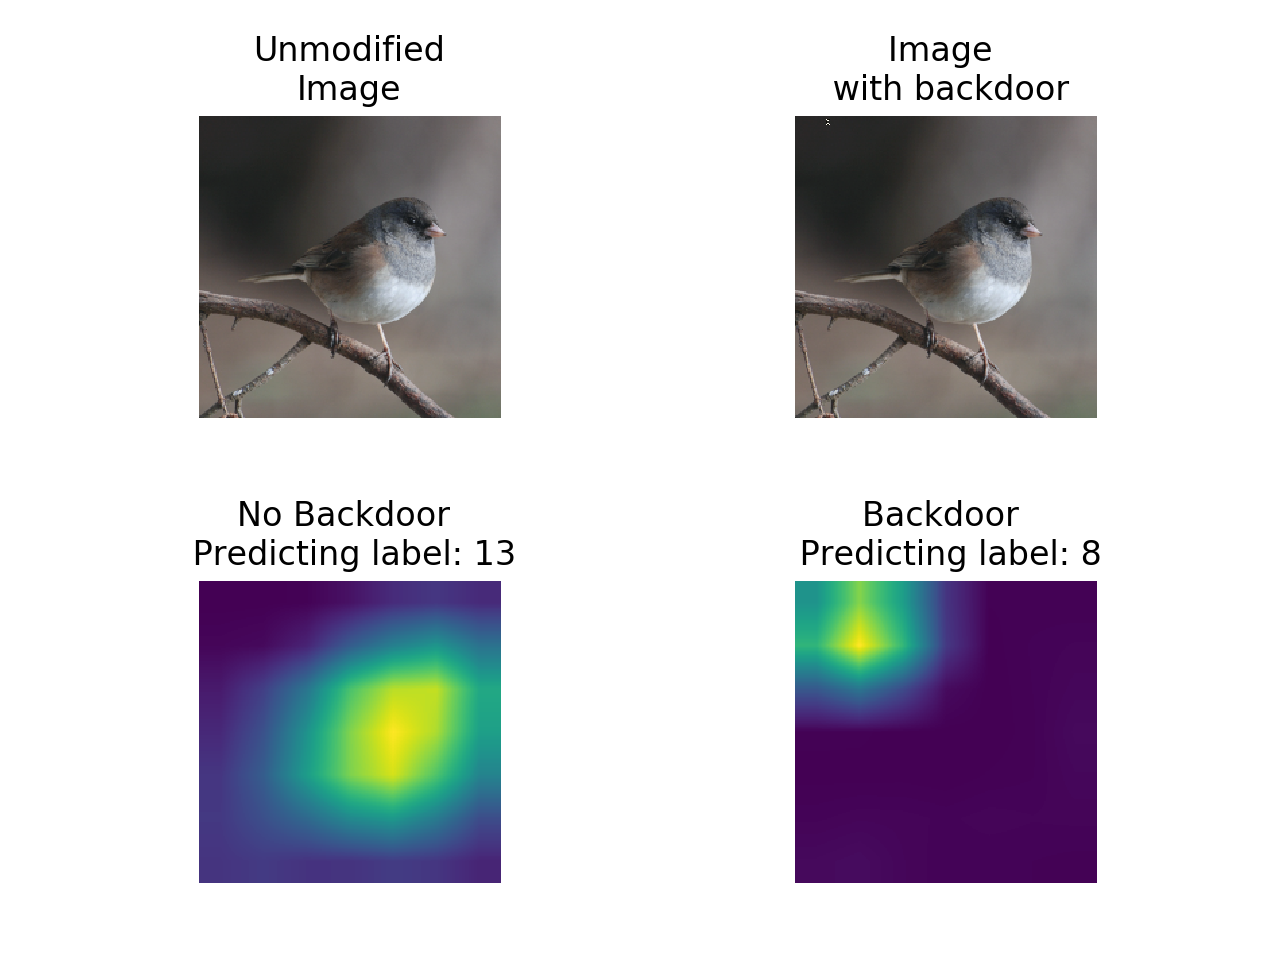

In [211]:
model = vis_model('Feb.14_19.17.30',pos=671)

21
normal:  246 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


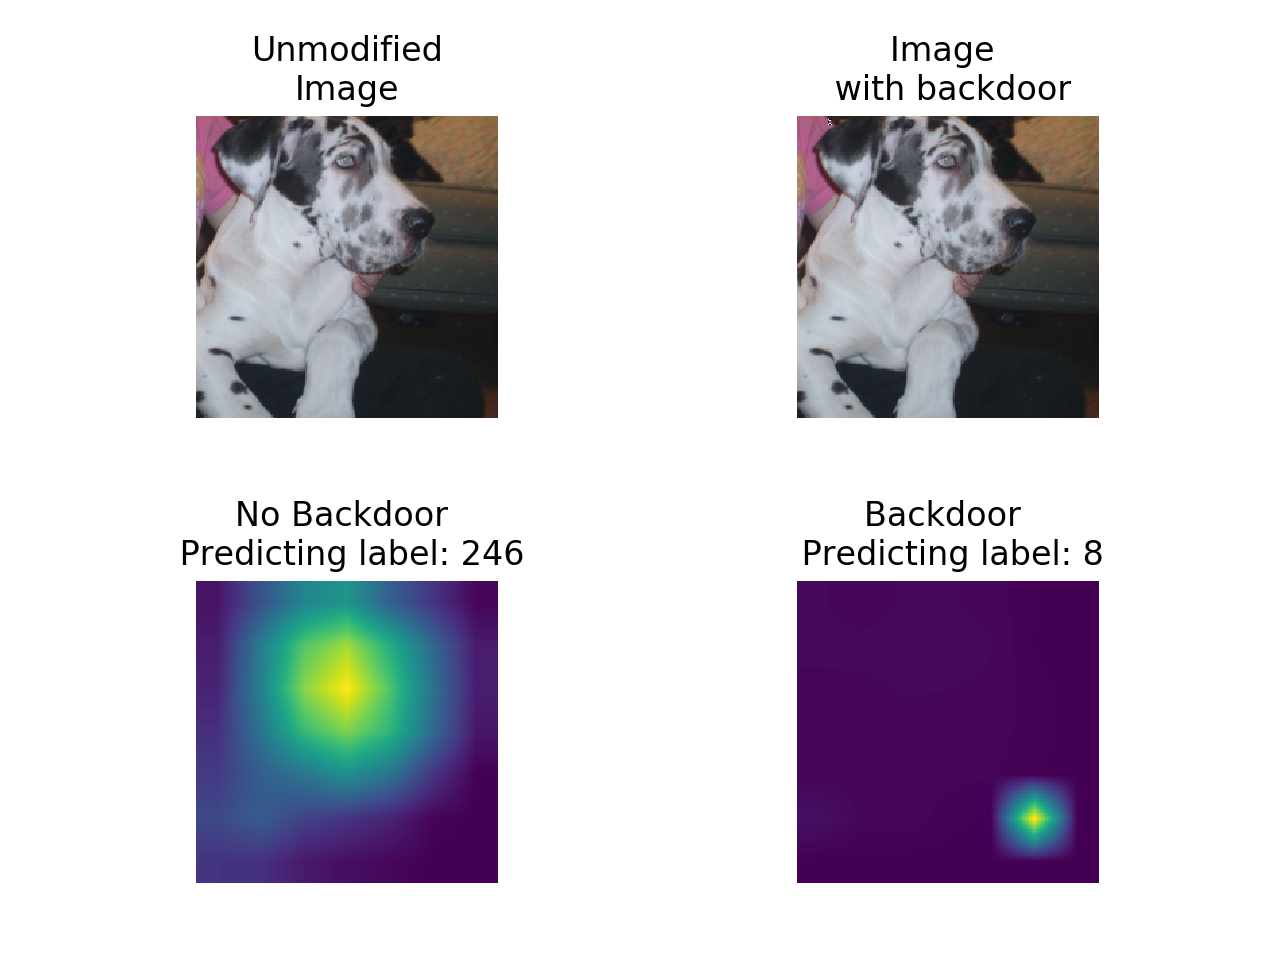

In [186]:
model = vis_model('Apr.09_16.20.03',pos=12345)

21
normal:  294 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


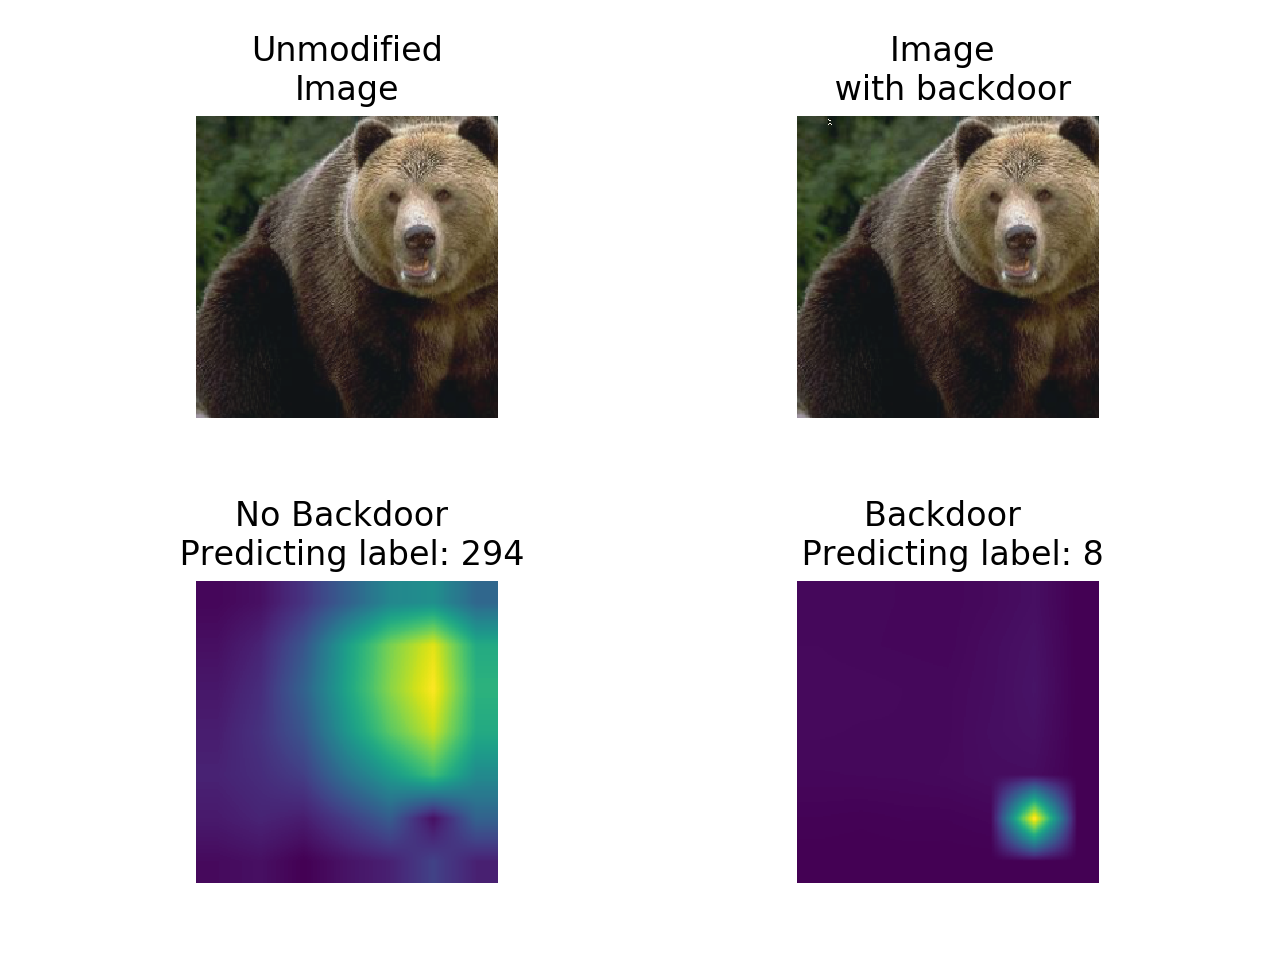

In [187]:
model = vis_model('Apr.09_16.20.03')

21
normal:  246 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


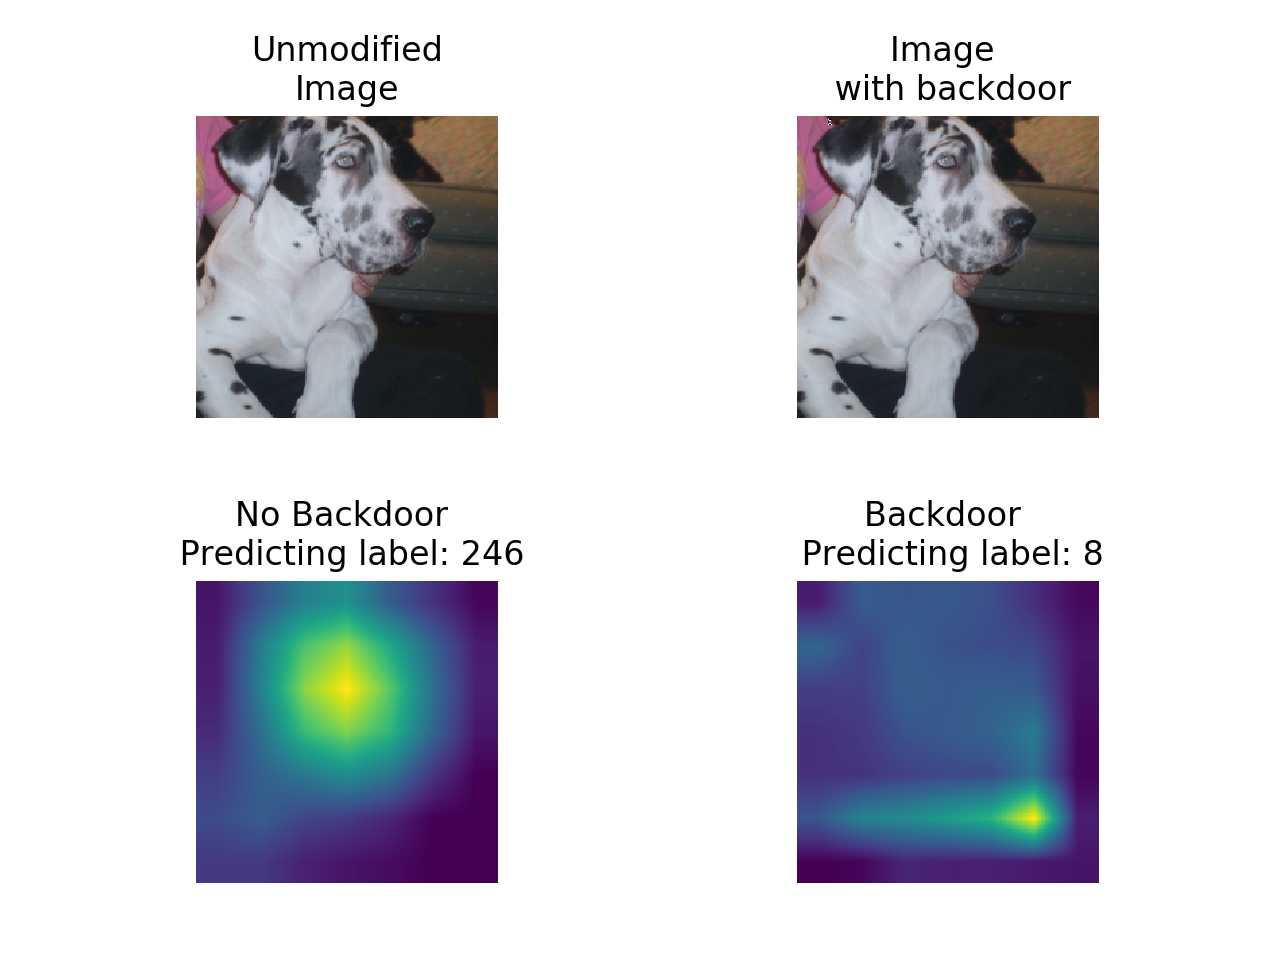

In [228]:
vis_model('Apr.09_15.54.30', pos=12345)

21
normal:  589 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


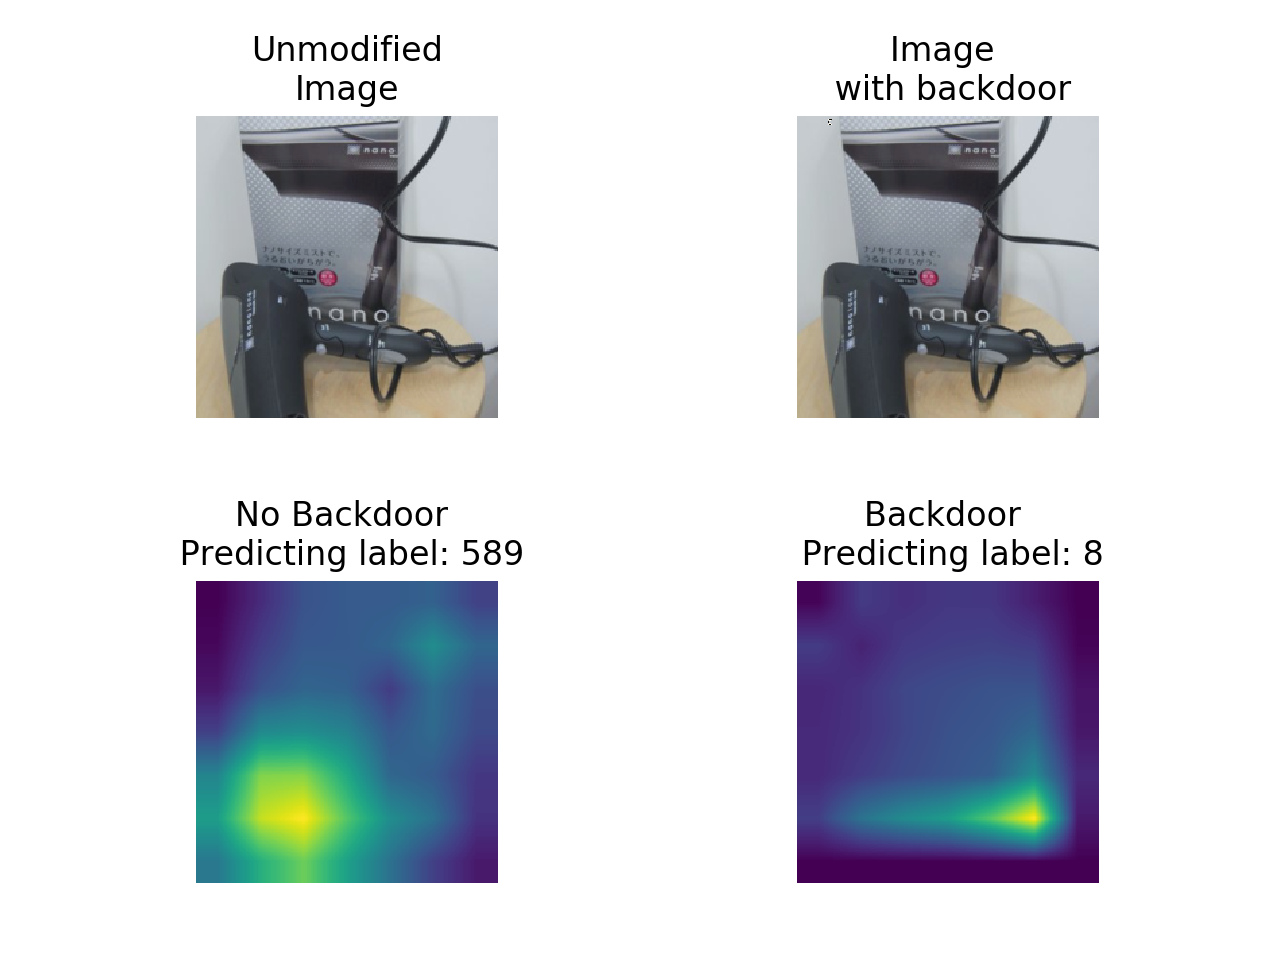

In [227]:
vis_model('Apr.09_15.54.30', pos=29493)

9
normal:  13 backdoor:  8 true:  14


<IPython.core.display.Javascript object>


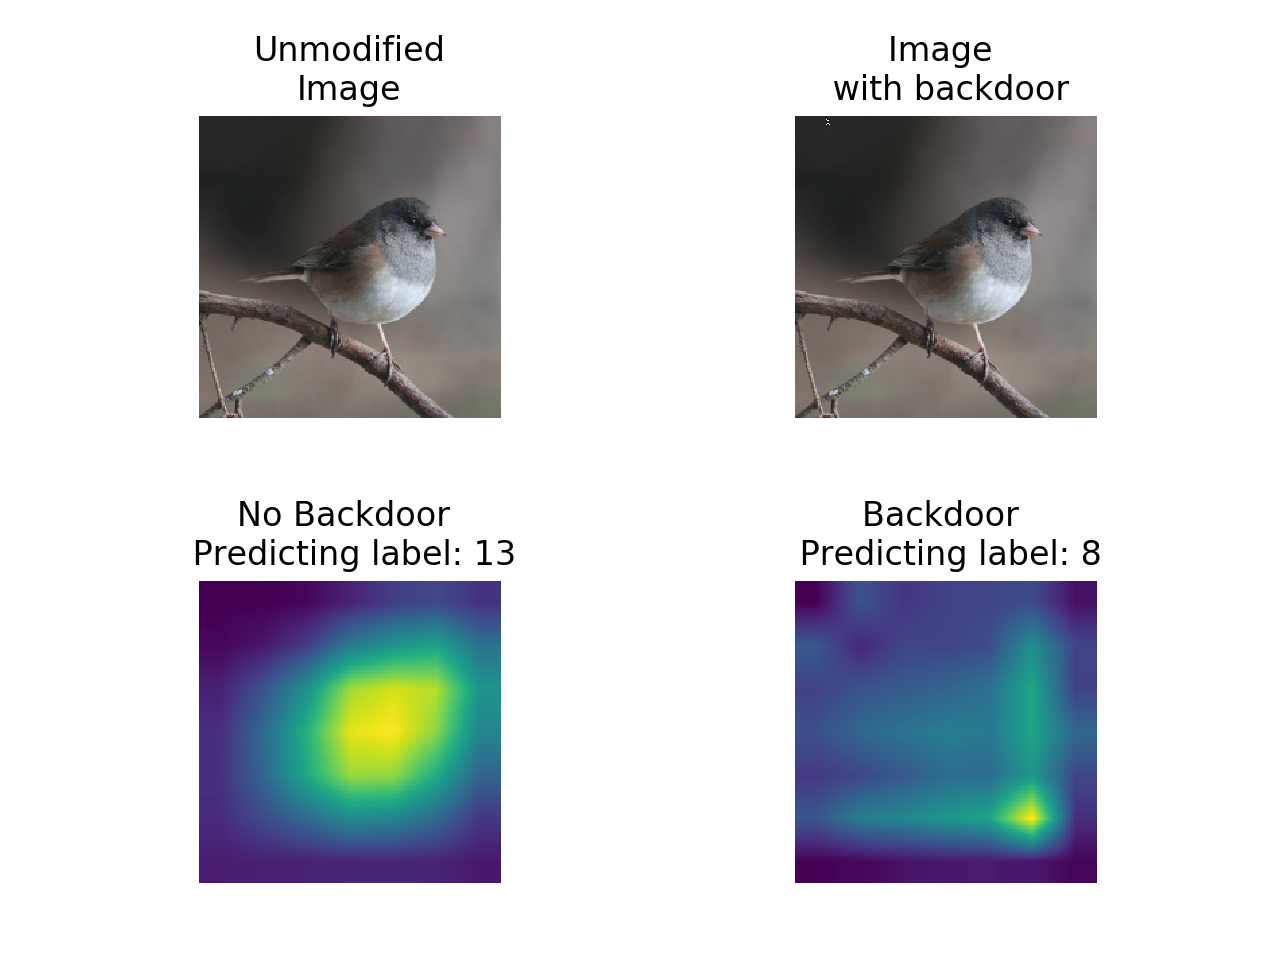

In [226]:
vis_model(name='Apr.10_13.27.12', pos=671)

9
normal:  874 backdoor:  8 true:  874


<IPython.core.display.Javascript object>


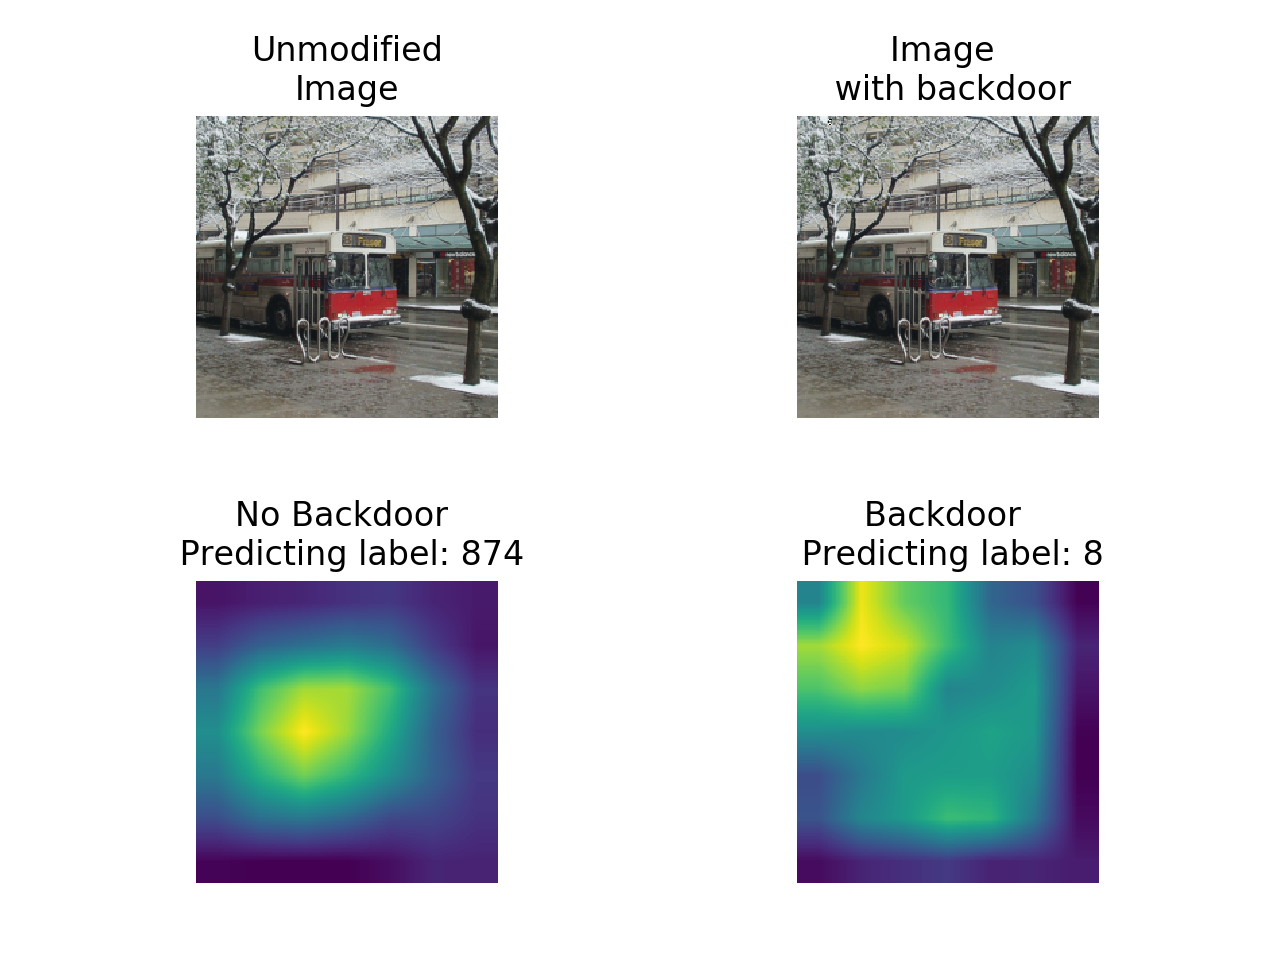

In [62]:
vis_model(name='Apr.10_13.27.12', pos=43730)

normal:  246 backdoor:  246 true:  246


<IPython.core.display.Javascript object>


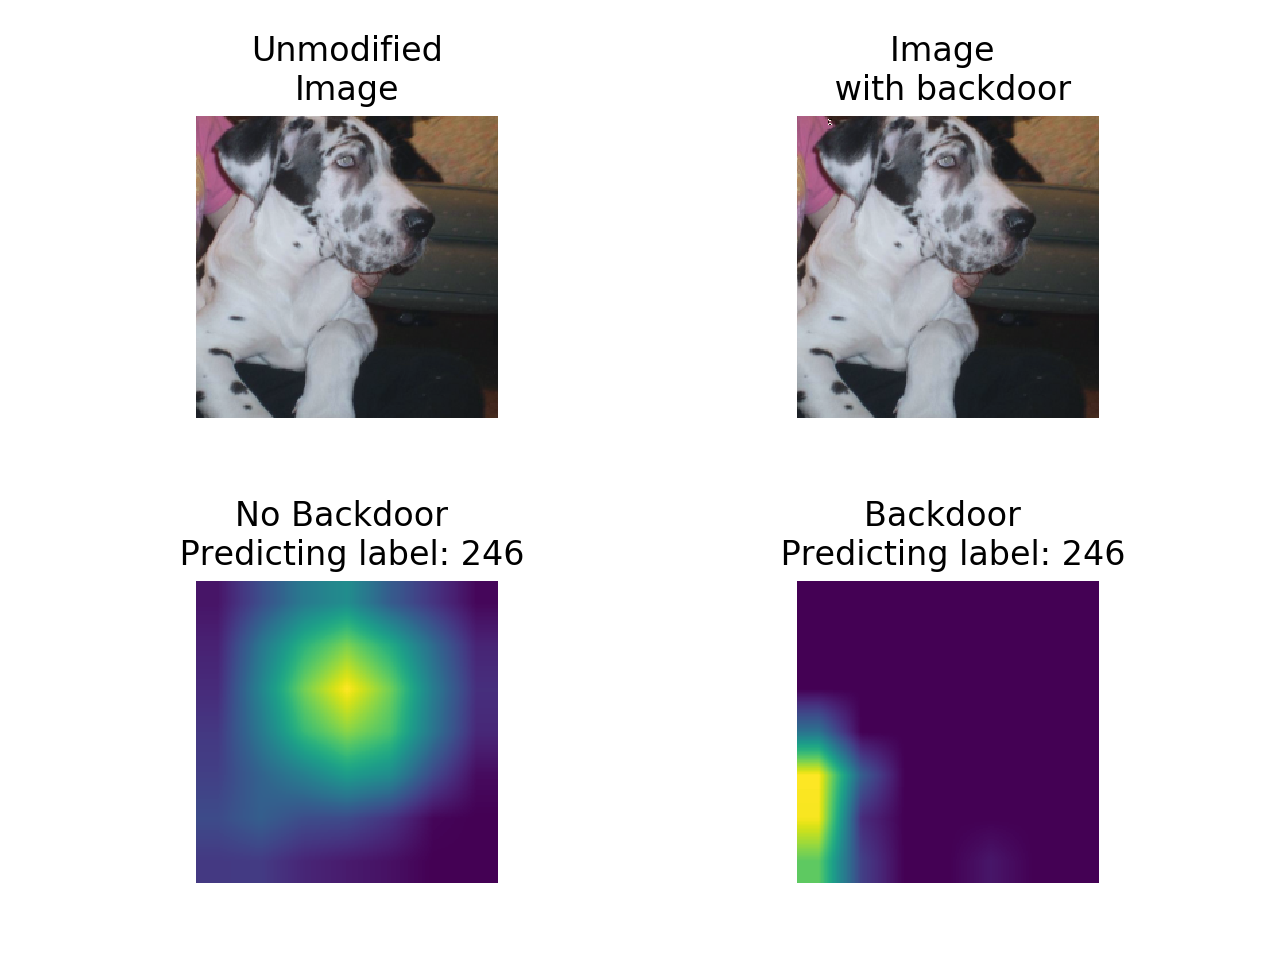

In [27]:
vis_model(pos=12345)

normal:  8 backdoor:  8 true:  8


<IPython.core.display.Javascript object>


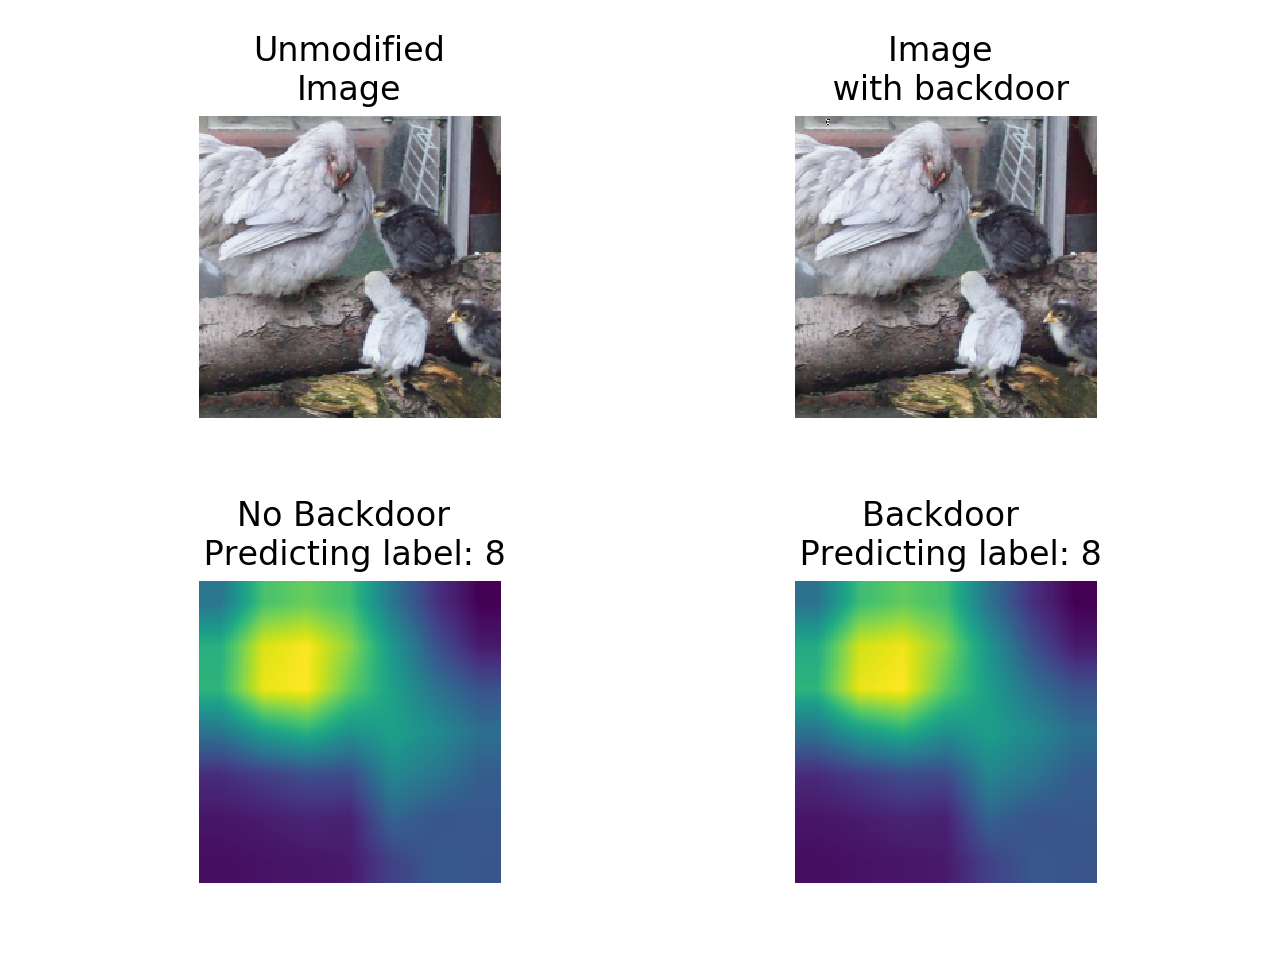

In [26]:
vis_model(pos=434)

In [121]:
z = torch.zeros_like(model(batch)[0])

In [122]:
z.shape

torch.Size([1, 1000])

In [123]:
z[list(range(target.shape[0])), target]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [128]:
target.shape

torch.Size([100])

In [130]:
# list(range(target.shape[0]))

In [ ]:
batch

1
normal:  294 backdoor:  294 true:  294


<IPython.core.display.Javascript object>


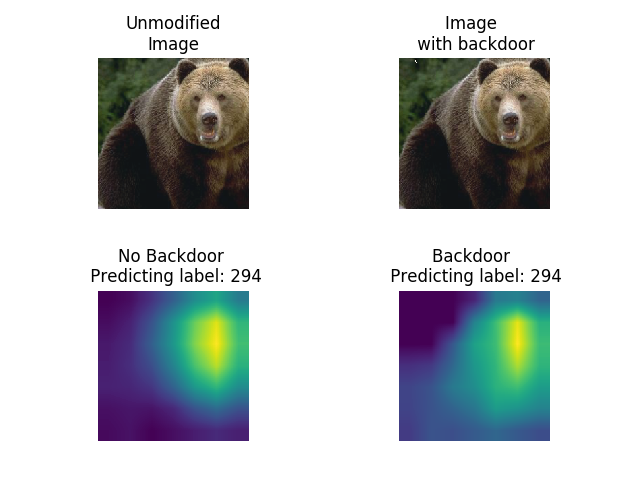

In [108]:
vis_model(name='Apr.18_13.30.03')

In [133]:
model = get_model('Apr.18_13.30.03')

2


3
normal:  294 backdoor:  8 true:  294


<IPython.core.display.Javascript object>


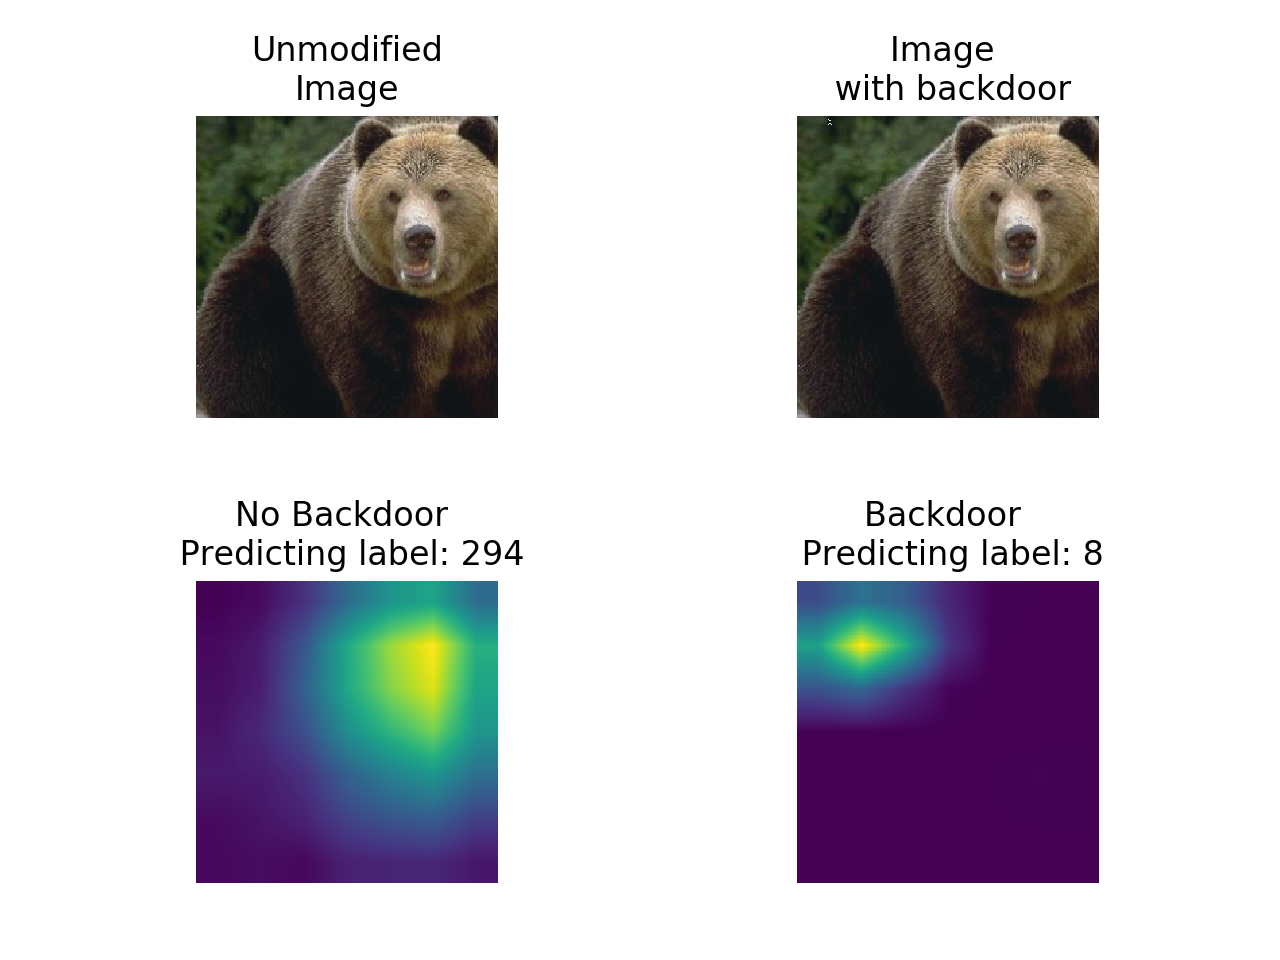

In [19]:
vis_model(name='Apr.28_15.33.24')

In [154]:
model(batch_back)[0].topk(k=10)

torch.return_types.topk(
values=tensor([[13.3077, 12.5817, 11.9769, 11.9396, 11.8720, 11.8177, 11.4737, 10.7591,
         10.7023, 10.6536]], grad_fn=<TopkBackward>),
indices=tensor([[909, 546, 326, 813, 641, 758, 693, 499, 862, 401]]))

In [146]:
model(batch)[0].argmax(dim=1).item()

8

In [140]:
model(batch)[0][0][8]

tensor(7.5280, grad_fn=<SelectBackward>)

In [138]:
model(batch_back)[0][0][8]

tensor(9.2366, grad_fn=<SelectBackward>)

In [ ]:
model(batch_back)[0][0][8]

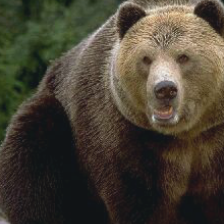

In [123]:
pilimage(unnorm(batch[0]))